## Scientific Publications Data Warehouse

Project 1: A Data Cube on top of Delta Lake (ETL)
#### *Purpose*
The purpose is to extract data about scientific publications from JSON data that describe, title, topic, authors, etc., about a large number of papers and populate a data warehouse to issue analytics queries using SQL.

We will use Spark DataFrames to extract and transform the data.

We will also use Spark tables (delta tables) to be used for dimensions and fact tables as will be shown below.

### *DWH Schema*

We will follow the proposed schema as shown:

DBLP Fact Table:
    - Date_ID (FK)
    - Keyword_ID (FK)
    - Type_ID (FK)
    - Publication_ID (FK)
    - Venue_ID (FK)
    - FOS_ID (FK)
    - ORG_ID (FK)
    - Author_ID (FK)
    - Lange_ID (FK)
    - AuthorRank

Keyword Table:
    - ID
    - Text

Type Table:
    - ID
    - Description

Publication Table:
    - ID
    - Title
    - Year
    - PageStart
    - PageEnd
    - DOI
    - PDF
    - URL
    - Abstract
    - IndexedAbstract
    - N_Citation

Venue Table:
    - ID
    - Name
    - City
    - Country

Date Table:
    - ID
    - Year
    - Month
    - Day

Language Table:
    - ID
    - Name

FOS Table:
    - ID
    - Field

ORG Table:
    - ID
    - Name
    - City
    - Country

Author Table:
    - ID
    - FirstName
    - LastName
    - MiddleName


### *Dataset*

The data source is https://www.aminer.org/citation, version 13, as it is the most detailed one in JSON
format. You can also check the schema of the respective data set on the same page under the  "Description" link – note that the schema may not correspond to the schema in the JSON file.


#### Dataschema of V13

_Backed to v11 schema, where id and references are in String form._*


| --- | --- | --- | ---
| Field Name | Field Type | Description | Example
| id | string | paper ID | 43e17f5b20f7dfbc07e8ac6e
| title | string | paper title | Data mining: concepts and techniques
| authors.name | string | author name | Jiawei Han
| authors.org | string | author affiliation | Department of Computer Science, University of Illinois at Urbana-Champaign
| authors.id | string | author ID | 53f42f36dabfaedce54dcd0c
| venue.id | string | paper venue ID | 53e17f5b20f7dfbc07e8ac6e
| venue.raw | string | paper venue name | Inteligencia Artificial, Revista Iberoamericana de Inteligencia Artificial
| year | int | published year | 2000
| keywords | list of strings | keywords | ["data mining", "structured data", "world wide web", "social network", "relational data"]
| fos.name | string | paper fields of study | Web mining
| fos.w | float | fields of study weight | 0.659690857
| references | list of strings | paper references | ["4909282", "16018031", "16159250",  "19838944", ...]
| n_citation | int | citation number | 40829
| page_start | string | page start | 11
| page_end | string | page end | 18
| doc_type | string | paper type: journal, book title... | book
| lang | string | detected language | en
| publisher | string | publisher | Elsevier
| volume | string | volume | 10
| issue | string | issue | 29
| issn | string | issn | 0020-7136
| isbn | string | isbn | 1-55860-489-8
| doi | string | doi | 10.4114/ia.v10i29.873
| pdf | string | pdf URL | //static.aminer.org/upload/pdf/1254/ 370/239/53e9ab9eb7602d970354a97e.pdf
| url | list | external links | ["http://dx.doi.org/10.4114/ia.v10i29.873", "http://polar.lsi.uned.es/revista/index.php/ia/ article/view/479"]
| abstract | string | abstract | Our ability to generate...
| indexed_abstract | dict | indexed abstract | {"IndexLength": 164, "InvertedIndex": {"Our": [0], "ability": [1], "to": [2, 7, ...]}}

### Extract

In [0]:
# let's fetch the data
# !wget https://originalstatic.aminer.cn/misc/dblp.v13.7z
# !7z x dblp.v13.7z


In [0]:
#%pip install graphframes

In [0]:
%pip install gender_guesser

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# we will read and process the data while cleaning it simultaneously

import json
import ast
import os

def process_json(file_name, split_size, output_prefix, offset=0, file_number=0):
    with open(file_name, 'r', encoding='utf-8') as ifh:
        # seek to the second line in the file
        if offset > 0:
            ifh.seek(offset)
        else:
            ifh.seek(1) # skip the first '['
        file_number = file_number
        checkpoint = []
        file_sizes = []
        end_of_file = False
        # we will keep looping until all the lines are read
        while not ifh or not end_of_file:
            file_number += 1
            # json_objects = [ast.literal_eval(build_json_object(ifh)) for _ in tqdm.notebook.tqdm(range(split_size))]
            json_objects = []
            while len(json_objects) < split_size:
                try:
                    json_objects.append(ast.literal_eval(build_json_object(ifh)))
                except:
                    end_of_file = True
                    break # we reached the end of the file
            print(f"Checkpoint {file_number}: {ifh.tell()}, objects processed: {len(json_objects)}")
            # write each json object to a file
            with open(f"{output_prefix}{file_number}.json", 'w', encoding='utf-8') as ofh:
                # this process yields smaller files than using json.dump w/ indent = 4
                for i, json_object in enumerate(json_objects):
                    if i == len(json_objects) - 1:
                        ofh.write(json.dumps(json_object) + "]")
                    elif i == 0:
                        ofh.write('[' + json.dumps(json_object) + ",")
                    else:
                        ofh.write(json.dumps(json_object[0]) + ",")
            # get the size of the file
            file_sizes.append(os.path.getsize(f"{output_prefix}{file_number}.json") / 1024 / 1024)
            checkpoint.append(ifh.tell())
            print(f"Checkpoint {file_number}: {checkpoint[-1]}, objects processed: {len(json_objects)}, size of file {file_number}: {file_sizes[-1]} MB")
            # break # for testing purposes
        print(f"Finished processing {file_name}, {file_number} files created.")
        return checkpoint, file_sizes

def clean_line(line):
    if "NumberInt" in line:
        line = line.replace("NumberInt", "") # NumberInt(123) -> (123)
        line = line.replace("(", '"') # (123) -> "123)
        line = line.replace(")", '"') # "123) -> "123"
    if ": null," in line or ": null" in line:
        line = line.replace("null", '""')
    return line

def build_json_object(fh):
    buffer = ''
    line = fh.readline()
    while line != "},\n":
        if not line:
            print("Reached end of file")
            return buffer[:-2]
        buffer += clean_line(line)
        line = fh.readline()
    buffer += line
    return buffer


In [0]:
# results = process_json('dblpv13.json', 100000, 'clean_dataset/dblpv13_clean_', offset=17260419910, file_number=53)
# results = process_json('dblpv13.json', 100000, 'clean_dataset/dblpv13_clean_')

### Transform

Here we will begin the transformation part of our pipeline. We will use delta tables and pyspark dataframes to do this. There are a few tasks that we must complete:
1. Drop publications with very short titles (one word, empty authors, etc.)
2. Visualize the number of citations
3. ISSN is sometimes filled with wrong values, we can either drop or make an effor to resolve using DOI for instance.
4. Defining the type of publication (journal, book, conference, etc.)
5. Resolving ambiguous author names
6. Resolving ambiguous or abbreviated conference and journal names using DBLP database.
7. Refining venues
8. Author gender
9. H-index of authors
10. Normalization of the field of study

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")


In [0]:
path_to_data = 'dbfs:/FileStore/tables/dblpv13_cleanv2_'
# path_to_data = 'dbfs:/FileStore/tables/small_'

In [0]:
# change the memory size depending
spark = SparkSession.builder \
    .appName("Project1") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.sql.warehouse.dir", "file:///tmp/spark-warehouse")\
    .config("spark.driver.memory", "16g")\
    .config("spark.executor.memory", "16g")\
    .config("spark.driver.maxResultSize", "16g")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.databricks.delta.checkLatestSchemaOnRead", "false")\
    .getOrCreate()

In [0]:
# gender
# %pip install gender_guesser
import gender_guesser.detector as gender

def get_author_gender(first_name):
    d = gender.Detector()
    gender_result = d.get_gender(first_name)
    if gender_result == "mostly_male":
        return "male"
    elif gender_result == "mostly_female":
        return "female"
    else:
        return gender_result

# with api / has limit
# import request
# def get_author_gender(first_name):
#     url = f'https://api.genderize.io/?name={first_name}'
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()
#         if 'gender' in data:
#             return data['gender']
#     return None

def add_author_gender(authors):
    genders = []
    for author in authors:
        if author is None:
            return None
        gender = get_author_gender(author.split()[0])
        genders.append(gender)
    return genders

In [0]:
# author names
import requests

def resolve_names(name):
    response = requests.get("https://dblp.org/search/author/api", params={"q": name, "format": "json"})
    if response.status_code == 200:
        result = response.json()
        if "result" in result and "hits" in result["result"]:
            if "hit" in result["result"]["hits"]:
                for hit in result["result"]["hits"]:
                    if "info" in hit and "author" in hit["info"]:
                        author_name = hit["info"]["author"]
#                     if author_name.lower() == name.lower():
                        return author_name
    return name


def add_resolved_names(authors):
    names = []
    for author in authors:
        name = resolve_names(author['name'])
        names.append(name)
    return names

In [0]:
# publ titles, venues
import requests

def resolve_data(request):
    response = requests.get("https://dblp.org/search/publ/api", params={"q": request, "format": "json"})
    if response.status_code == 200:
        result = response.json()
        if "result" in result and "hits" in result["result"]:
            hits = result["result"]["hits"]
            if "hit" in hits:
                for hit in hits["hit"]:
                    if all(key in hit["info"] for key in ["title", "venue"]):
                        resolved_data = hit["info"]["title"]
                        refined_venue = hit["info"]["venue"]
                        return (resolved_data, refined_venue)
    
    return (None, None)
  
resolve_data('A stepwise framework for the normalization of array CGH data.')

Out[31]: ('A stepwise framework for the normalization of array CGH data.',
 'BMC Bioinform.')

In [0]:
def extract_institution(org):
    if org:
        # Split the org field by comma and return the first substring
        return substring(split(org, ",")[0], 1, -1)
    else:
        return None

In [0]:
from pyspark.sql.functions import explode, desc, row_number
from pyspark.sql.window import Window


# Function to merge two schemas
def merge_schemas(schema1, schema2):
    merged_fields = {field.name: field for field in schema1}
    for field in schema2:
        if field.name not in merged_fields:
            merged_fields[field.name] = field
    return StructType(sorted(merged_fields.values(), key=lambda field: field.name))

  
def preprocess_dataframe(df):
    df = df.dropDuplicates()
    
    # 1. Drop publications with very short titles (one word, empty authors, etc.)
    df = df.filter(df.title.isNotNull()) \
        .filter(length(df.title) > 5) \
        .filter(col('title').contains(' '))\
        .filter(~df.title.rlike(".*Editorial.*")) \
        .filter(~df.title.rlike(".*Forward.*")) \
        .filter(~df.title.rlike(".*Preface.*")) \
        .filter(~df.title.rlike(".*Conference.*")) \
        .filter(~df.title.rlike(".*Proceedings.*")) \
        .filter(~df.title.rlike(".*Symposium.*")) \
        .filter(~df.title.rlike(".*Workshop.*")) \
        .filter(~df.title.rlike(".*Tutorial.*")) \
        .filter(~df.title.rlike(".*Forum.*"))

    df = df.filter(length(df.abstract) > 0)

    df = df.filter(df.issn.isNotNull()) \
        .filter(length(df.issn) > 5)
    
    # 2. Visualize the number of citations
    df = df.withColumn("n_citation_int", col("n_citation").cast("integer"))
    
    # 3. ISSN is sometimes filled with wrong values, we can either drop or make an effor to resolve using DOI for instance.
    df = df.filter(~df.doi.rlike(".*[a-zA-Z]+.*"))
    
    
    # 4. Defining the type of publication (journal, book, conference, etc.)
    # Create a new column with the default publication type of 'Conference'
    df = df.withColumn('pub_type', lit('Conference'))
    # Update the publication type based on the 'venue.raw', 'volume', and 'issue' columns
    df = df.withColumn('pub_type', when(col('venue.raw').contains('@'), 'Workshop')
                                   .when((col('volume') != '') | (col('issue') != ''), 'Journal')
                                   .otherwise(col('pub_type')))
    
    # 5. Resolving ambiguous author names
    resolve_name_udf = udf(add_resolved_names, StringType())
    df = df.withColumn("resolved_authors", resolve_name_udf(df.authors))
    
    # 6. Resolving ambiguous or abbreviated conference and journal names using DBLP database
    # 7. Refining venues
    resolve_data_udf = udf(resolve_data, StructType([StructField("title", StringType()), StructField("venue", StringType())]))

    df = df.withColumn("resolved_data", resolve_data_udf(df.title))
    df = df.withColumn("resolved_title", df.resolved_data.title)
#     df = df.filter(col("resolved_title").isNotNull())
#     df = df.withColumn("refined_venue", df.resolved_data.venue)
#     df = df.drop("resolved_data")
    
    
#     # 8. Author gender
    get_author_gender_udf = udf(add_author_gender, StringType())
    df = df.withColumn('authors_gender', get_author_gender_udf(df.resolved_authors))
    
    
    # 9.
    # Define a UDF that applies the extract_institution function to each author
    #extract_institution_udf = udf(extract_institution)

    # Create a new column called "Institutions" that contains the institution name for each author
    #df = df.withColumn("Institutions", explode(expr("transform(authors, x -> extract_institution_udf(x.org))")))


    
    # 10. 
    


    return df


In [0]:
# We read JSON files with schema inference and preprocess them
json_files = [f"{path_to_data}{i}.json" for i in range(1,2)]
dataframes = [preprocess_dataframe(spark.read.option("inferSchema", "true").json(file)) for file in json_files]

In [0]:
display(dataframes[0].limit(5))

_id,abstract,authors,doi,fos,isbn,issn,issue,keywords,lang,n_citation,page_end,page_start,pdf,references,title,url,venue,volume,year,n_citation_int,pub_type,resolved_authors,resolved_data,resolved_title,authors_gender
53e99792b7602d9701f5b2c7,"In two-channel competitive genomic hybridization microarray experiments, the ratio of the two fluorescent signal intensities at each spot on the microarray is commonly used to infer the relative amounts of the test and reference sample DNA levels. This ratio may be influenced by systematic measurement effects from non-biological sources that can introduce biases in the estimated ratios. These biases should be removed before drawing conclusions about the relative levels of DNA. The performance of existing gene expression microarray normalization strategies has not been evaluated for removing systematic biases encountered in array-based comparative genomic hybridization (CGH), which aims to detect single copy gains and losses typically in samples with heterogeneous cell populations resulting in only slight shifts in signal ratios. The purpose of this work is to establish a framework for correcting the systematic sources of variation in high density CGH array images, while maintaining the true biological variations.After an investigation of the systematic variations in the data from two array CGH platforms, SMRT (Sub Mega base Resolution Tiling) BAC arrays and cDNA arrays of Pollack et al., we have developed a stepwise normalization framework integrating novel and existing normalization methods in order to reduce intensity, spatial, plate and background biases. We used stringent measures to quantify the performance of this stepwise normalization using data derived from 5 sets of experiments representing self-self hybridizations, replicated experiments, detection of single copy changes, array CGH experiments which mimic cell population heterogeneity, and array CGH experiments simulating different levels of gene amplifications and deletions. Our results demonstrate that the three-step normalization procedure provides significant improvement in the sensitivity of detection of single copy changes compared to conventional single step normalization approaches in both SMRT BAC array and cDNA array platforms.The proposed stepwise normalization framework preserves the minute copy number changes while removing the observed systematic biases.","List(List(53f43184dabfaedf4354af59, null, mkhojast@bccrc.ca, 5b86c4a8e1cd8e14a3b0a117, Mehrnoush Khojasteh, null, null, null, null, British Columbia Cancer Research Centre, Vancouver, BC, Canada|Department of Electrical and Computer Engineering, University of British Columbia, Vancouver, BC, Canada, null, 5f71b28e1c455f439fe3cad2, null, null, null), List(548a7e4ddabfaed7b5fa41f6, null, wanlam@bccrc.ca, 5b8690dee1cd8e14a34ed9ef, Wan L Lam, null, null, null, null, British Columbia Cancer Research Centre, Vancouver, BC, Canada, null, null, null, null, null), List(54480291dabfae87b7dc1fa9, null, rababw@ece.ubc.ca, 5b86c1e5e1cd8e14a39d1258, Rabab K Ward, null, null, null, null, Department of Electrical and Computer Engineering, University of British Columbia, Vancouver, BC, Canada, null, 5f71b28e1c455f439fe3cad2, null, null, null), List(54311531dabfae8f2912ab95, null, cmacaula@bccrc.ca, 5b8690dee1cd8e14a34ed9ef, Calum MacAulay, null, null, null, 0000-0003-4440-2792, British Columbia Cancer Research Centre, Vancouver, BC, Canada, null, null, null, null, null))",10.1186/1471-2105-6-274,"List(CDNA Arrays, Normalization (statistics), Pattern recognition, Biology, Population Heterogeneity, High density, Comparative genomic hybridization, Artificial intelligence, Mega-, Genetics, DNA microarray, Gene expression microarray)",,1471-2105,1,"List(microarrays, copy number, genetic variation, gene expression, nucleic acid hybridization, gene amplification, algorithms, bioinformatics, calibration)",en,110,274,274,https://static.aminer.cn/upload/pdf/program/53e99792b7602d9701f5b2

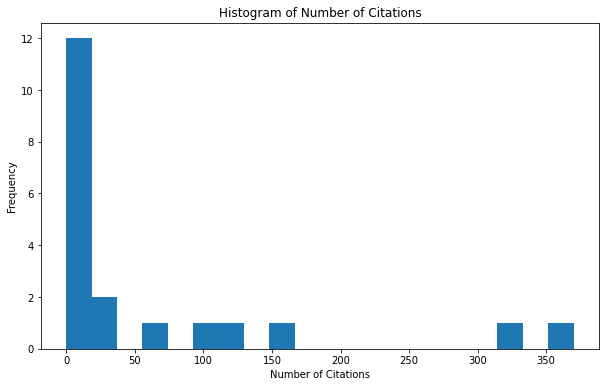

In [0]:
# 2. Visualize the number of citations
import matplotlib.pyplot as plt

citations_hist = dataframes[0].limit(20).select("n_citation_int").rdd.flatMap(lambda x: x).histogram(20)

citations_bins = citations_hist[0]
citations_counts = citations_hist[1]

plt.figure(figsize=(10, 6))

plt.hist(citations_bins[:-1], bins=citations_bins, weights=citations_counts)

plt.xlabel("Number of Citations")
plt.ylabel("Frequency")
plt.title("Histogram of Number of Citations")

plt.show()

In [0]:
merged_schema = dataframes[0].schema
for df in dataframes[1:]:
    merged_schema = merge_schemas(merged_schema, df.schema)

dataframes_with_merged_schema = [df.selectExpr(*merged_schema.fieldNames()) for df in dataframes]

combined_df = dataframes_with_merged_schema[0].limit(20)
for df in dataframes_with_merged_schema[1:]:
    combined_df = combined_df.unionByName(df.limit(20), allowMissingColumns=True)

combined_df.write.format("delta").mode("append").option("mergeSchema", "true").save("dbfs:/FileStore/tables/delta/dblpv13")

In [0]:
combined_df = combined_df.withColumn("publication_id", monotonically_increasing_id()) \
    .withColumn("author_id", monotonically_increasing_id()) \
    .withColumn("venue_id", monotonically_increasing_id()) \
    .withColumn("fos_id", monotonically_increasing_id()) \
    .withColumn("org_id", monotonically_increasing_id()) \
    .withColumn("date_id", monotonically_increasing_id()) \
    .withColumn("keyword_id", monotonically_increasing_id()) \
    .withColumn("type_id", monotonically_increasing_id()) \
    .withColumn("lang_id", monotonically_increasing_id())


dblp_fact_table = combined_df.select("date_id", "keyword_id", "type_id", "publication_id", "venue_id",
                                      "fos_id", "org_id", "author_id", "lang_id")

keyword_table = combined_df.select("keyword_id",
                                   col("keywords").alias("text"))


venue_table = combined_df.select("venue_id",
#                                  col("refined_venue").alias("name"),
                                 col("venue.type").alias("type"),
                                 col("venue.raw").alias("raw"),
                                 col("venue._id").alias("vid"))
venue_table = venue_table.filter(venue_table.type.isNotNull())

date_table = combined_df.select("date_id",
                                year("year").alias("year"))

language_table = combined_df.select("lang_id",
                                    col("lang").alias("name"))


fos_table = combined_df.select("fos_id",
                               col("fos").alias("field"))

author_table = combined_df.select("author_id",
                                  col("resolved_authors").alias("name"),
                                  col("authors.org").alias("org"),
                                  col("authors.gid").alias("gid"),
                                  col("authors.orgid").alias("orgid"),
                                  col("authors_gender").alias("gender"))

publication_table = combined_df.select("publication_id",
                                       col("resolved_title").alias("name"),
                                       col("abstract").alias("description"),
                                       col("doi").alias("doi"),
                                       col("issn").alias("issn"),
                                       col("isbn").alias("isbn"),
                                       col("url").alias("url"),
                                       col("pdf").alias("pdf"),
                                       col("page_start").alias("page_start"),
                                       col("page_end").alias("page_end"),
                                       col("volume").alias("volume"),
                                       col("issue").alias("issue"),
                                       col("n_citation").alias("n_citation"),
                                       col("pub_type").alias("pub_type"))


In [0]:
dblp_fact_table.write.format("delta").mode("append").option("mergeSchema", "true").save("dbfs:/FileStore/tables/delta/dblp_fact_table")
# keyword_table.write.format("delta").mode("append").save("dbfs:/FileStore/tables/delta/keyword_table")
# venue_table.write.format("delta").mode("append").save("dbfs:/FileStore/tables/delta/venue_table")
# date_table.write.format("delta").mode("append").save("dbfs:/FileStore/tables/delta/date_table")
# language_table.write.format("delta").mode("append").save("dbfs:/FileStore/tables/delta/language_table")
# fos_table.write.format("delta").mode("append").save("dbfs:/FileStore/tables/delta/fos_table")
author_table.write.format("delta").mode("append").option("mergeSchema", "true").save("dbfs:/FileStore/tables/delta/author_table")
publication_table.write.format("delta").mode("append").option("mergeSchema", "true").save("dbfs:/FileStore/tables/delta/publication_table")


In [0]:
# load table from delta lake
dblp_fact_table = spark.read.format("delta").load("dbfs:/FileStore/tables/delta/dblp_fact_table")
# venue_table = spark.read.format("delta").load("dbfs:/FileStore/tables/delta/venue_table")
# keyword_table = spark.read.format("delta").load("dbfs:/FileStore/tables/delta/keyword_table")
# date_table = spark.read.format("delta").load("dbfs:/FileStore/tables/delta/date_table")
# language_table = spark.read.format("delta").load("dbfs:/FileStore/tables/delta/language_table")
# fos_table = spark.read.format("delta").load("dbfs:/FileStore/tables/delta/fos_table")
author_table = spark.read.format("delta").load("dbfs:/FileStore/tables/delta/author_table")
publication_table = spark.read.format("delta").load("dbfs:/FileStore/tables/delta/publication_table")

In [0]:
# display(dblp_fact_table)

# dbutils.fs.rm("dbfs:/FileStore/tables/delta/dblp_fact_table", recurse=True)
# # dbutils.fs.rm("dbfs:/FileStore/tables/delta/venue_table", recurse=True)
# # dbutils.fs.rm("dbfs:/FileStore/tables/delta/keyword_table", recurse=True)
# # dbutils.fs.rm("dbfs:/FileStore/tables/delta/date_table", recurse=True)
# # dbutils.fs.rm("dbfs:/FileStore/tables/delta/language_table", recurse=True)
# # dbutils.fs.rm("dbfs:/FileStore/tables/delta/fos_table", recurse=True)
# dbutils.fs.rm("dbfs:/FileStore/tables/delta/author_table", recurse=True)
# dbutils.fs.rm("dbfs:/FileStore/tables/delta/publication_table", recurse=True)

Out[41]: True

In [0]:
# display(author_table)

In [0]:
# display(publication_table)

In [0]:
# pip install networkx

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from graphframes import GraphFrame
import networkx as nx
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Define author_id and n_hops
author_id = "8589934593"
n_hops = 3

# Define author, publication, and fact tables
author_vertices = author_table.select(col("author_id").alias("id"), col("name"))
publication_vertices = publication_table.select(col("publication_id").alias("id"), col("name"))
edges = dblp_fact_table.selectExpr("author_id as src", "publication_id as dst").withColumn("relationship", lit("AUTHORED_BY"))

# Create the GraphFrame
g = GraphFrame(author_vertices.union(publication_vertices), edges)

# Show vertices and edges
g.vertices.show()
g.edges.show()

# Perform BFS
paths = g.bfs(fromExpr=f"id = '{author_id}'", toExpr=f"id != '{author_id}'", maxPathLength=n_hops)

# Display the paths
paths.show()

# Find relationships between authors and publications
results = g.find("(a1)-[e1]->(p); (a2)-[e2]->(p)") \
    .filter("a1.name != a2.name")

# Display the results
results.show()

# Convert the GraphFrame to a NetworkX graph
nx_graph = nx.from_pandas_edgelist(g.edges.toPandas(), 'src', 'dst')

# Draw the graph
nx.draw(nx_graph, with_labels=True)
plt.show()


---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-4261571854869103>:4
      2 from pyspark.sql.functions import col, lit
      3 from graphframes import GraphFrame
----> 4 import networkx as nx
      5 import matplotlib.pyplot as plt
      7 # Create a Spark session

File /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py:171, in _create_import_patch.<locals>.import_patch(name, globals, locals, fromlist, level)
    166 thread_local._nest_level += 1
    168 try:
    169     # Import the desired module. If you’re seeing this while debugging a failed import,
    170     # look at preceding stack frames for relevant error information.
--> 171     original_result = python_builtin_import(name, globals, locals, fromlist, level)
    173     is_root_import = thread_local._nest_level == 1
    174     # `level` represents the number of leading dots in

In [0]:
# AUTHORSHIP RELATIONSHIP
from graphframes import GraphFrame

author_vertices = author_table.select(col("author_id").alias("id"), col("name"))
publication_vertices = publication_table.select(col("publication_id").alias("id"), col("name"))
edges = dblp_fact_table.selectExpr("author_id as src", "publication_id as dst").withColumn("relationship", lit("AUTHORED_BY"))

g = GraphFrame(author_vertices.union(publication_vertices), edges)

display(g)

g.vertices.show()
g.edges.show()

GraphFrame(v:[id: bigint, name: string], e:[src: bigint, dst: bigint ... 1 more field])+---+--------------------+
| id|                name|
+---+--------------------+
|  0|[Mehrnoush Khojas...|
|  1|[Xiaohui Tan, Pen...|
|  2|[G. Sahoo, Rajesh...|
|  3|[Álvaro Gonzalo-A...|
|  4|           [Kun Gao]|
|  0|A stepwise framew...|
|  1|                null|
|  2|Hiding Secret Inf...|
|  3|Model-Free Adapti...|
|  4|A Uniform Paralle...|
+---+--------------------+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  0|  0| AUTHORED_BY|
|  1|  1| AUTHORED_BY|
|  2|  2| AUTHORED_BY|
|  3|  3| AUTHORED_BY|
|  4|  4| AUTHORED_BY|
|  0|  0| AUTHORED_BY|
|  1|  1| AUTHORED_BY|
|  2|  2| AUTHORED_BY|
|  3|  3| AUTHORED_BY|
|  4|  4| AUTHORED_BY|
+---+---+------------+



In [0]:
author_vertices = author_table.select(col("author_id"), col("name"))
organization_vertices = author_table.select(col("author_id").alias("org_id"), col("org"))
organization_vertices = organization_vertices.withColumn("name", col("org").cast("string")).drop("org")
# display(author_vertices)
display(organization_vertices)
# edges = dblp_fact_table.selectExpr("author_id as src", "org_id as dst").withColumn("relationship", lit("WORKS_FOR"))

edges = author_table.alias("a1").join(author_table.alias("a2"), "author_id") \
    .filter("a1.name != a2.name") \
    .selectExpr("a1.author_id as src", "a2.author_id as dst")

g = GraphFrame(author_vertices.union(organization_vertices), edges)

display(g)

g.vertices.show()
g.edges.show()

org_id,name
0,"[British Columbia Cancer Research Centre, Vancouver, BC, Canada|Department of Electrical and Computer Engineering, University of British Columbia, Vancouver, BC, Canada, British Columbia Cancer Research Centre, Vancouver, BC, Canada, Department of Electrical and Computer Engineering, University of British Columbia, Vancouver, BC, Canada, British Columbia Cancer Research Centre, Vancouver, BC, Canada]"
1,"[Beijing Normal Univ, Sch Informat Sci & Technol, Beijing 100875, Peoples R China, Beijing Normal Univ, Sch Informat Sci & Technol, Beijing 100875, Peoples R China, Informat Engineer Coll Capital Normal Univ, Beijing 100048, Peoples R China, Beijing Normal Univ, Sch Informat Sci & Technol, Beijing 100875, Peoples R China]"
2,"[null, null]"
3,"[Univ Cantabria, Dept Commun Engn, Santander 39140, Spain, Univ Cantabria, Dept Commun Engn, Santander 39140, Spain]"
4,"[Computer Science and Information Technology College, Zhejiang Wanli University, China]"


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-3756243372507396>:12
      6 # edges = dblp_fact_table.selectExpr("author_id as src", "org_id as dst").withColumn("relationship", lit("WORKS_FOR"))
      8 edges = author_table.alias("a1").join(author_table.alias("a2"), "author_id") \
      9     .filter("a1.name != a2.name") \
     10     .selectExpr("a1.author_id as src", "a2.author_id as dst")
---> 12 g = GraphFrame(author_vertices.union(organization_vertices), edges)
     14 display(g)
     16 g.vertices.show()

File /local_disk0/spark-7a6f7192-97e9-4094-a371-3251b9a0c839/userFiles-2d3d71e2-96bc-4b31-a5ca-0523c3351eba/addedFile21099602818813190687b549b12_e8fa_429b_aa94_9eb6583489bd_graphframes_0_8_2_spark3_0_s_2_12_0d356-c9e68.jar/graphframes/graphframe.py:77, in GraphFrame.__init__(self, v, e)
     75 # Check that provided DataFrames contain required columns
     76 i

In [0]:
author_dblp_publication = author_table.join(
    dblp_fact_table, "author_id"
).join(publication_table, "publication_id")

In [0]:
co_authors = author_dblp_publication.alias('d1').join(
    author_dblp_publication.alias('d2'), "publication_id"
).filter('d1.author_id == d2.author_id').select(col('d1.author_id').alias('author1'), col('d2.author_id').alias('author2'), col('d2.publication_id').alias('publication'))

In [0]:
co_author_counts = (
    co_authors.groupby("author1", "author2")
    .agg({"publication": "count"})
    .withColumnRenamed("count(publication)", "co_author_count")
)

In [0]:
authors_vertices = author_table.selectExpr("author_id as id", "name")


coauthors_edges = co_author_counts.selectExpr(
    "author1 as src", "author2 as dst", "co_author_count as weight"
)

coauthorship_graph = GraphFrame(author_vertices, coauthor_edges)

In [0]:
coauthorship_graph.edges.show()

+---+---+------+
|src|dst|weight|
+---+---+------+
|  1|  1|     4|
|  4|  4|     4|
|  3|  3|     4|
|  2|  2|     4|
|  0|  0|     4|
+---+---+------+



In [0]:
authors_edges = author_dblp_publication.selectExpr("author_id as src", "publication_id as dst").distinct()

In [0]:
authorship_graph = GraphFrame(authors_vertices, authors_edges)

In [0]:
authorship_graph.edges.show()

+---+---+
|src|dst|
+---+---+
|  1|  1|
|  4|  4|
|  3|  3|
|  2|  2|
|  0|  0|
+---+---+



In [0]:
#Find the number of publications authored by each author:
authorship_graph.edges.groupBy("src").count().orderBy("src").show()

+---+-----+
|src|count|
+---+-----+
|  0|    1|
|  1|    1|
|  2|    1|
|  3|    1|
|  4|    1|
+---+-----+



In [0]:
cites_edges = dblp_fact_table.join(
    publication_table,
    dblp_fact_table.publication_id == publication_table.publication_id
).select(
    dblp_fact_table.publication_id.alias("src"),
    publication_table.publication_id.alias("dst")
)

publications_vertices =  publication_table.selectExpr("publication_id as id", "name")

In [0]:
cites_graph = GraphFrame(publications_vertices, cites_edges)

In [0]:
cites_graph.edges.show()

+---+---+
|src|dst|
+---+---+
|  0|  0|
|  1|  1|
|  2|  2|
|  3|  3|
|  4|  4|
|  0|  0|
|  1|  1|
|  2|  2|
|  3|  3|
|  4|  4|
+---+---+

